In [4]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime

from IPython.display import display, HTML
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn import ensemble, svm, tree, linear_model
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, FunctionTransformer
from sklearn.feature_selection import VarianceThreshold,f_regression,mutual_info_regression, SelectKBest, RFE, SequentialFeatureSelector
from sklearn.preprocessing import OneHotEncoder , MinMaxScaler, MultiLabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

%load_ext autoreload
%autoreload 2

import plotly.io as pio
pio.renderers.default = 'iframe'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
## Local Utils File
from utils.constants import *
from utils.eda import *
from utils.melissa_utils import *
from utils.Bhushan_utils import *
from utils.lta_omv_scraper import *
from utils.models import Regression
from utils.regression_evaluation import RegressionEvaluate

In [6]:
train_df = pd.read_csv(f"{local_path}/{folder}/{train_dataset}")
val_df = pd.read_csv(f"{local_path}/{folder}/{val_dataset}")

### Pre prep work

In [7]:
train_numeric_columns = train_df.drop(columns=["price","indicative_price","listing_id"]).select_dtypes(include=['int64', 'float64']).columns
val_numeric_columns = val_df.drop(columns=["price","indicative_price","listing_id"]).select_dtypes(include=['int64', 'float64']).columns
train_numeric_columns == val_numeric_columns

all_df = pd.concat([train_df, val_df],axis=0)
X_data = pd.concat([train_df[train_numeric_columns], val_df[val_numeric_columns]],axis=0)
scaled_data = StandardScaler().fit_transform(X_data[train_numeric_columns])
scaled_data  =pd.DataFrame(scaled_data,columns=train_numeric_columns)
y_data = pd.concat([train_df["price"], val_df["price"]],axis=0)

## Feature Transformation

In [8]:
def log_transform(x):
    """ 
    Calculate log adding 1 to avoid calculation errors if x is very close to 0.
    """
    return np.log(x+1)

def exp_transform(x):
    """
    Inverse of log_transform.
    """
    return np.exp(x) - 1

def transform_data(data:pd.DataFrame, cols:list, transform_type:str):
    transformers= {
       "quantile_transform" : QuantileTransformer(output_distribution='normal', random_state=0),
       "yeo_johnson" : PowerTransformer(method='yeo-johnson', standardize=False),
       "log_transform": FunctionTransformer(func=log_transform, inverse_func=exp_transform)
    }
    transformed_data = transformers[transform_type].fit_transform(data)
    transformed_data = pd.DataFrame(transformed_data,columns=cols)
    transformed_data["data_type"] = transform_type
    return transformed_data

In [9]:
cols = ['curb_weight','power','engine_cap','no_of_owners','depreciation','coe','road_tax','dereg_value','mileage',
 'omv','arf','coe_age_left','car_age','cylinder_cnt','emission_data']
transform_all_data = X_data[cols].copy()
transform_all_data["data_type"] = "original"

# transformed_data = transform_data(
#     transform_all_data[cols], cols, "quantile_transform")
box_cox_transformed_data = transform_data(
    transform_all_data[cols], cols, "yeo_johnson")
log_transform_transformed_data = transform_data(
    transform_all_data[cols], cols, "log_transform")
transform_all_data = pd.concat(
    [transform_all_data, box_cox_transformed_data,log_transform_transformed_data],axis=0)

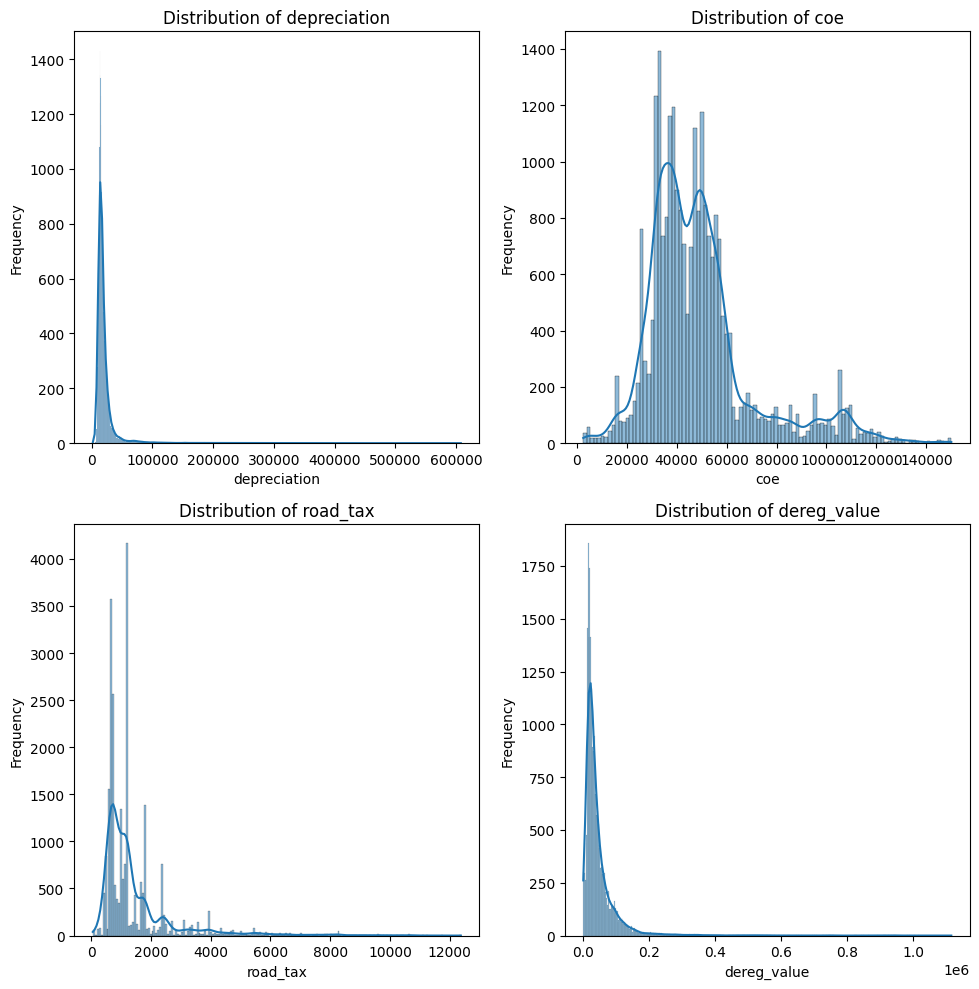

In [13]:
# cols = ['curb_weight','power','engine_cap','no_of_owners',
# 'depreciation','coe','road_tax','dereg_value',
# 'mileage','omv','arf','coe_age_left',
# 'age_range','car_age','cylinder_cnt','emission_data']
cols = ['depreciation','coe','road_tax','dereg_value']

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Iterate over the numeric columns and create distribution plots
for i, column in enumerate(cols):
    sns.histplot(data=X_data[cols], x=column, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {column}', fontsize=12)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(cols), len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

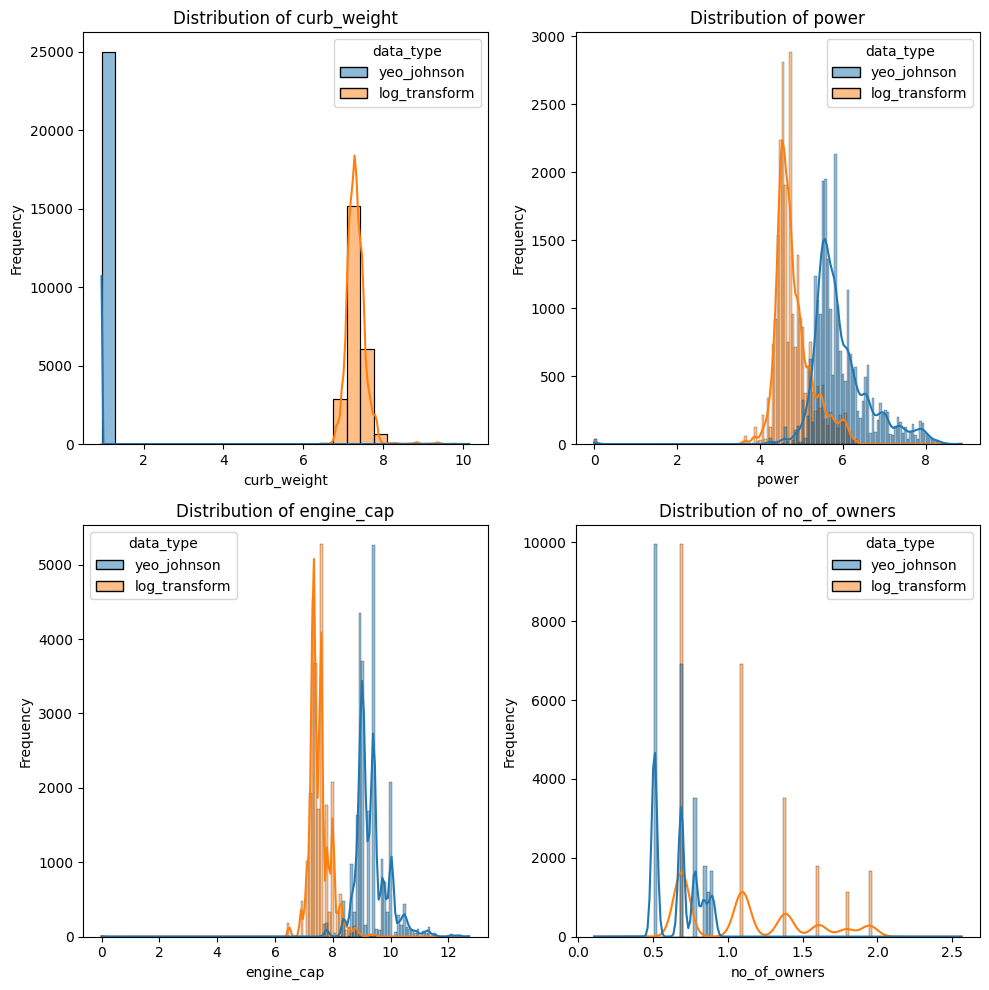

In [11]:
# cols = ['curb_weight','power','engine_cap','no_of_owners',
# 'depreciation','coe','road_tax','dereg_value',
# 'mileage','omv','arf','coe_age_left',
# 'age_range','car_age','cylinder_cnt','emission_data']
cols = ['curb_weight','power','engine_cap','no_of_owners']

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Iterate over the numeric columns and create distribution plots
transform_all_data = transform_all_data[transform_all_data.data_type != "original"]

for i, column in enumerate(cols):
    sns.histplot(data=transform_all_data, x=column, hue="data_type", kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {column}', fontsize=12)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(cols), len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

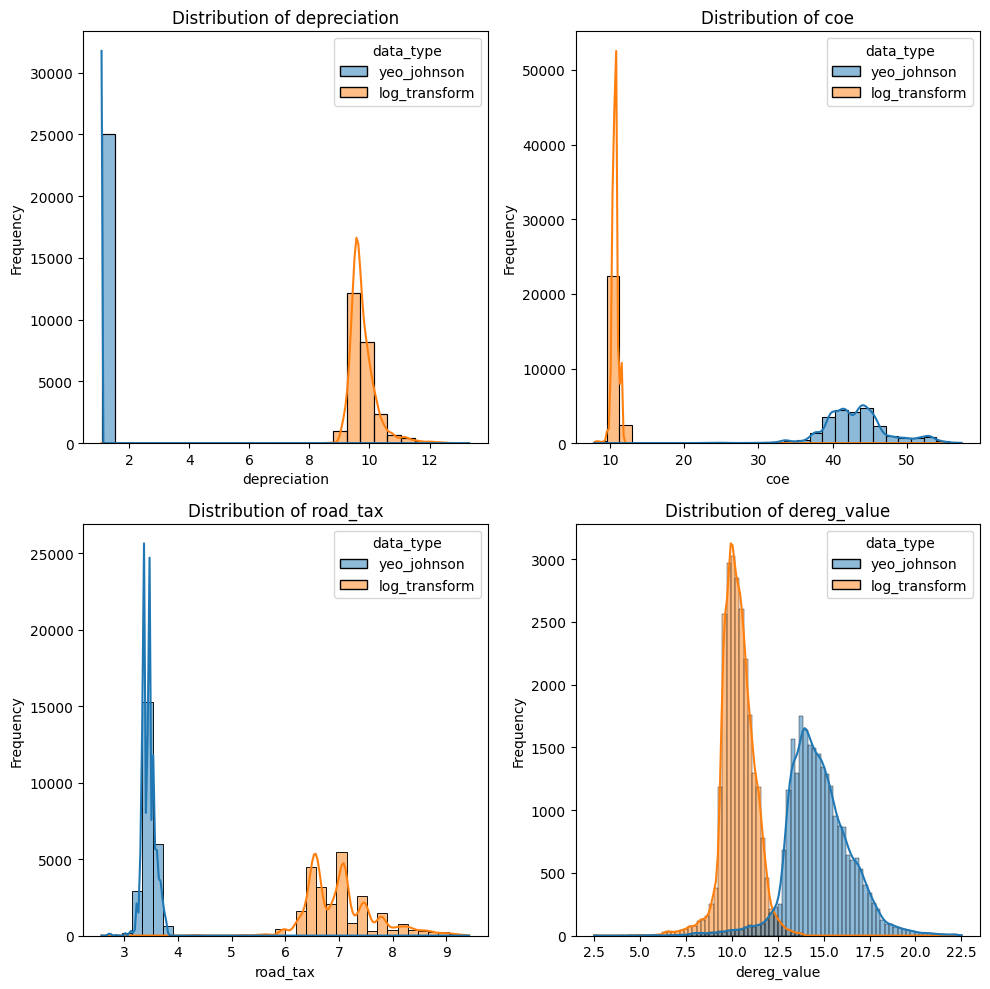

In [12]:
cols = [
'depreciation','coe','road_tax','dereg_value']

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Iterate over the numeric columns and create distribution plots
for i, column in enumerate(cols):
    sns.histplot(data=transform_all_data, x=column, hue="data_type", kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {column}', fontsize=12)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(cols), len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
cols = ['curb_weight','power','engine_cap','no_of_owners',
'depreciation','coe','road_tax','dereg_value',
'mileage','omv','arf','coe_age_left',
'age_range','car_age','cylinder_cnt','emission_data']

## Feature Selection

### Filter Methods

In [42]:
# Variation Thresholding
# Removing variation with less than 25% variation
variance_selector = VarianceThreshold(threshold = 0.25)
variance_selector.fit(X_data)
# True means that it has high variation and false means low variation (lower than 25%)
cols_with_var_unscaled = X_data.columns[variance_selector.get_support()].tolist()

In [43]:
# Variation Thresholding
# Removing variation with less than 25% variation
variance_selector = VarianceThreshold(threshold = 0.25)
variance_selector.fit(scaled_data)
# True means that it has high variation and false means low variation (lower than 25%)
cols_with_var = scaled_data.columns[variance_selector.get_support()].tolist()

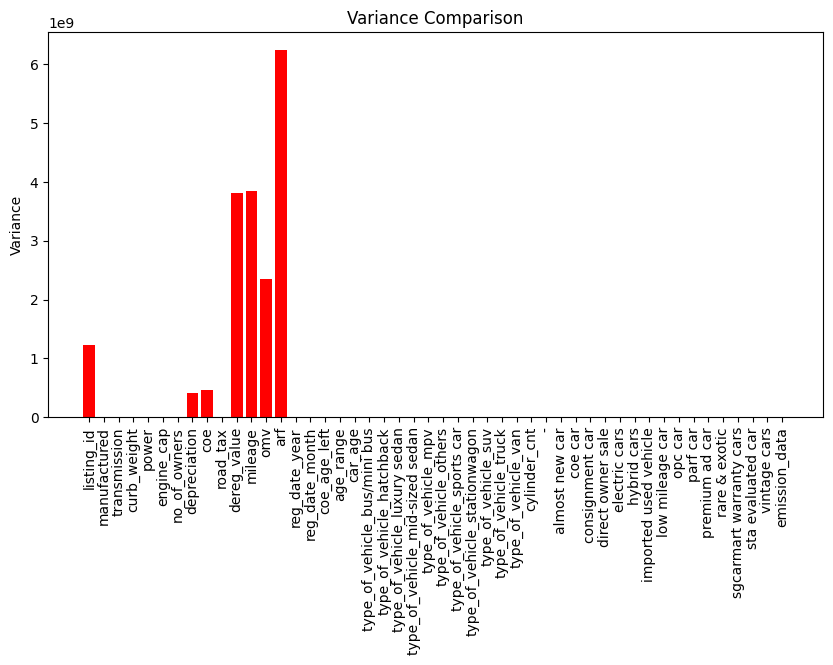

In [43]:
# Create a bar chart
plt.figure(figsize=(10,5))
plt.bar(X_data.columns, height=variance_selector.variances_, color='red')
plt.xticks(rotation='vertical')
plt.ylabel('Variance')
plt.title('Variance Comparison')
plt.show()

In [47]:
# Anova
f_value_unscaled = f_regression(X_data, y_data)

In [48]:
f_value = f_regression(scaled_data, y_data)

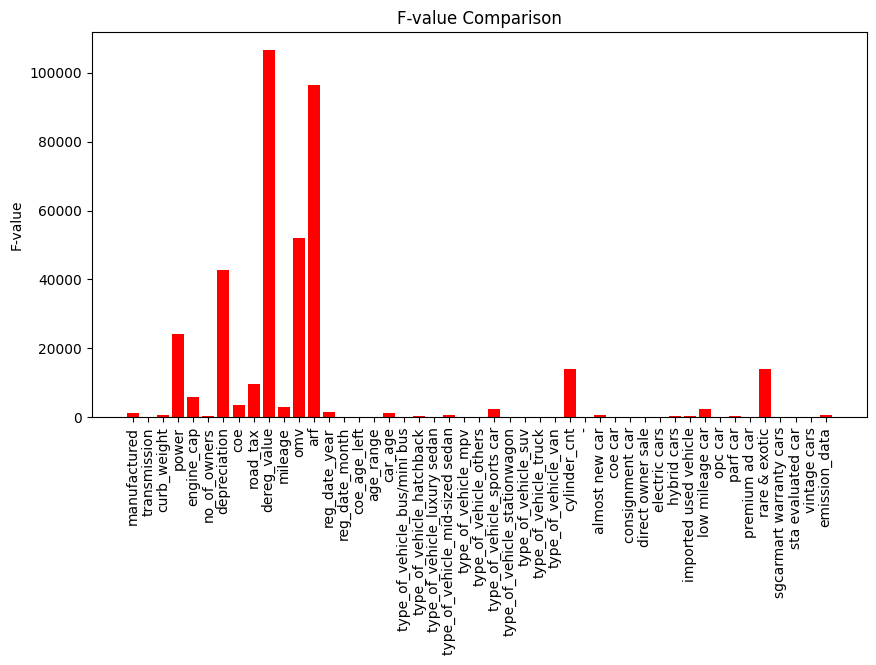

In [51]:
"""
ANOVA F-value estimates the degree of linearity between the input feature (i.e., independent 
features) and the output feature (i.e., dependent feature).A high F-value indicates a high 
degree of linearity and a low F-value indicates a low degree of linearity.
"""

# Create a bar chart
plt.figure(figsize=(10,5))
plt.bar(X_data.columns, height=f_value[0], color='red')
plt.xticks(rotation='vertical')
plt.ylabel('F-value')
plt.title('F-value Comparison')
plt.show()

In [49]:
## Mutual Information
"""
Mutual information (MI) measures the dependence of one variable to another by quantifying the
 amount of information obtained about one feature, through the other feature. MI is symmetric 
 and non-negative and is equal to zero if and only if two random variables are independent,
and higher values mean higher dependency.
"""

# create mutual_info_classif object
MI_score = mutual_info_regression(X_data, y_data, random_state=0)

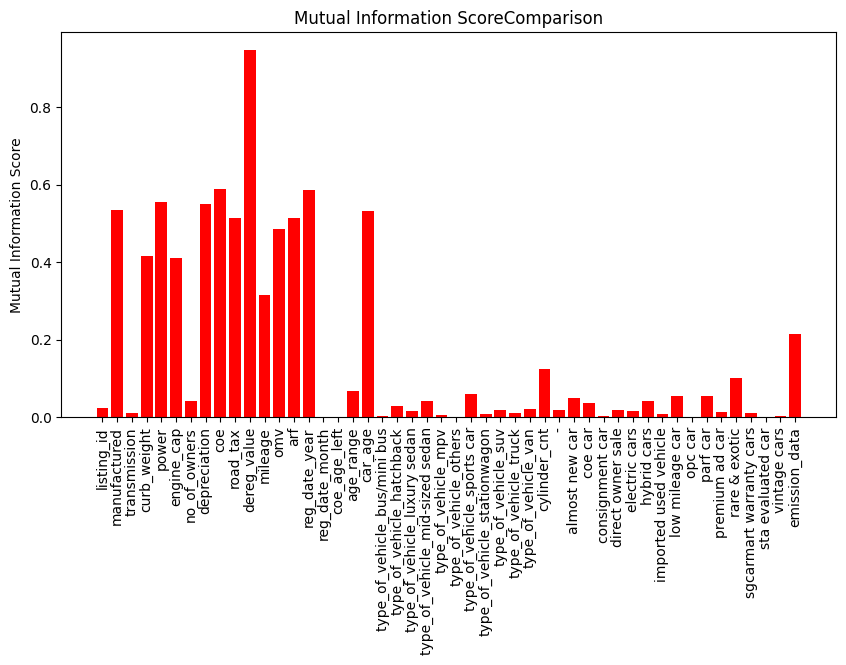

In [51]:
# Create a bar chart
variable = "Mutual Information Score"
plt.figure(figsize=(10,5))
plt.bar(X_data.columns, height=MI_score, color='red')
plt.xticks(rotation='vertical')
plt.ylabel(f'{variable}')
plt.title(f'{variable}Comparison')
plt.show()

### Kbest selector as a wrapper

f_regression is suitable for linear regression problems, while mutual_info_regression is more suitable for non-linear regression problems

In [59]:
selector = SelectKBest(score_func=mutual_info_regression, k=5)
selector.fit(X_data, y_data)
print(selector)
X_data.columns[selector.get_support()]

SelectKBest(k=5, score_func=<function mutual_info_regression at 0x7feee3d25550>)


Index(['power', 'depreciation', 'coe', 'dereg_value', 'reg_date_year'], dtype='object')

In [60]:
selector = SelectKBest(score_func=f_regression, k=5)
selector.fit(X_data, y_data)
print(selector)
X_data.columns[selector.get_support()]

SelectKBest(k=5, score_func=<function f_regression at 0x7fef10a6cc10>)


Index(['power', 'depreciation', 'dereg_value', 'omv', 'arf'], dtype='object')

### Wrapper Methods

**Sequential Forward Selection (SFS)**
Pros: Small feature sets: SFS can be computationally feasible if you don’t have too many features to test.
Situations with potential multicollinearity: Since it builds up the feature set incrementally, it can sometimes avoid including highly correlated features

Cons: Can miss interactions between features that only show up when certain combinations are selected.

**Sequential Backward Selection (SBS)**
Pros: Large feature sets: SBS is helpful if you have many features and want to reduce the dimensionality without losing significant predictive power. 
Cases where you expect most features to be irrelevant: It starts with all features, so it’s good if you suspect only a few features are relevant.

Cons: Like SFS, it can miss feature interactions that could improve the model.

**Recursive Feature Elimination (RFE)**

Pros: High-dimensional datasets: RFE is suitable for cases where feature interactions are crucial, as it iteratively re-evaluates feature importance.
When you need a robust, optimized subset: RFE tends to find the optimal set better than purely sequential approaches, particularly when interactions exist between features.

Feature importance ranking: It’s useful when you need not just a subset of features but also an ordered ranking of their importance.

cons : Computationally more expensive than SFS and SBS because it repeatedly fits the model after each feature elimination.

In practice, RFE often performs best in terms of producing a highly optimized subset, especially with models like Support Vector Machines (SVMs) or tree-based models where recursive elimination can leverage inherent feature importance.

In [22]:
## Recursive Feature Elimination (RFE)
model = ensemble.RandomForestRegressor()
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_data[cols_with_var], y_data)
ranking = rfe.ranking_

In [31]:
X_data[cols_with_var].columns[rfe.support_]
ranking

Index(['power', 'depreciation', 'dereg_value', 'arf', 'reg_date_year'], dtype='object')

In [11]:
N_FEAT = len(cols_with_var)
num_irrelevant_features_eliminated = np.arange(N_FEAT - 1, -1, -2)
rmse_list = []
for i in num_irrelevant_features_eliminated:
    rfe = RFE(model, n_features_to_select=(N_FEAT — i))
    rfe.fit(train_df[cols_with_var], train_df["price"])
    y_pred = rfe.predict(val_df[cols_with_var])
    rmse = root_mean_squared_error(val_df["price"], y_pred)
    rmse_list.append(rmse)

plt.figure(figsize=(8, 6))
plt.plot(num_irrelevant_features_eliminated, accuracy_list, marker='o')
plt.xlabel("Number of Irrelevant Features Eliminated")
plt.ylabel("RMSE")
plt.title("Model Performance as Irrelevant Features are Eliminated (RFE)")
plt.grid(True)
plt.show()

SyntaxError: invalid character '—' (U+2014) (3159272822.py, line 2)

In [ ]:
## Sequential Forward Selection

N_FEAT = len(cols_with_var)
num_irrelevant_features_eliminated = np.arange(N_FEAT — 1, -1, -1)
rmse_list = []
for i in num_irrelevant_features_eliminated:
    # Backward just select the backwards one
    ffs = SequentialFeatureSelector(
    model, n_features_to_select=(N_FEAT — i),  scoring='neg_root_mean_squared_error', direction="forward")
    ffs.fit(train_df[cols_with_var], train_df["price"])
    y_pred = ffs.predict(val_df[cols_with_var])
    rmse = root_mean_squared_error(val_df["price"], y_pred)
    rmse_list.append(rmse)

plt.figure(figsize=(8, 6))
plt.plot(num_irrelevant_features_eliminated, accuracy_list, marker='o')
plt.xlabel("Number of Irrelevant Features Eliminated")
plt.ylabel("RMSE")
plt.title("Model Performance as Irrelevant Features are Eliminated (ffs)")
plt.grid(True)
plt.show()

### Embedded Methods

### Correlation Plot

Text(0.5, 1.0, 'Features Correlating with Price')

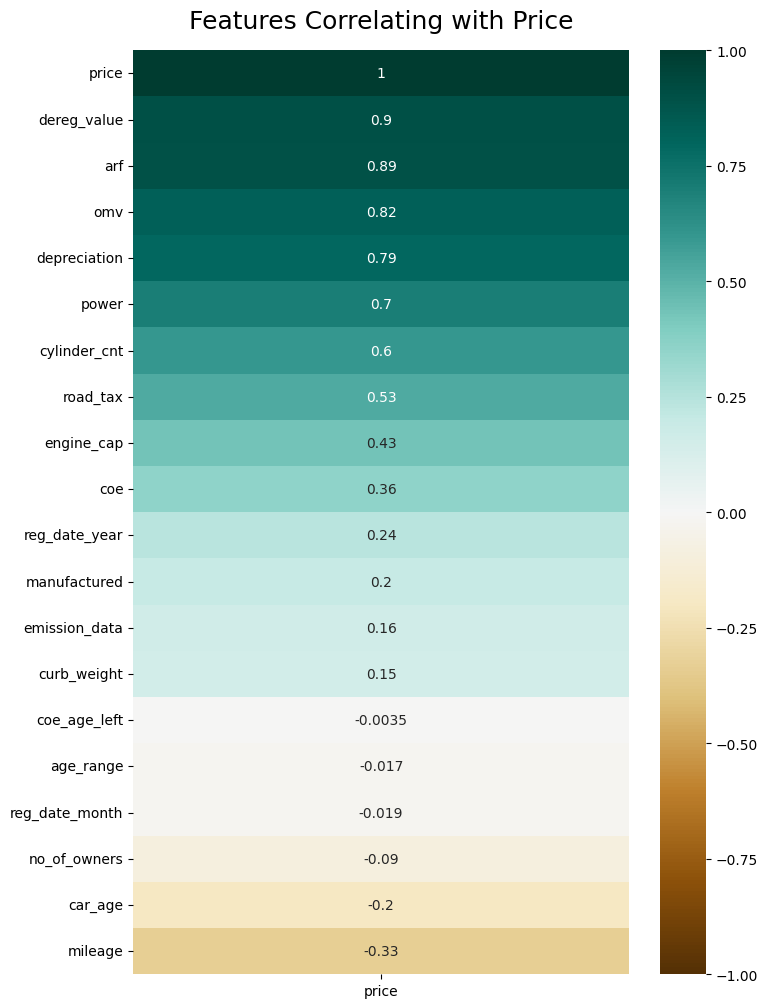

In [85]:
# Just Price Relations
cols = ['manufactured','curb_weight','power','engine_cap','no_of_owners','depreciation','coe','road_tax','dereg_value','mileage',
 'omv','arf','reg_date_year','reg_date_month','coe_age_left','age_range','car_age','cylinder_cnt','emission_data','price']
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(all_df[cols].corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':18}, pad=16)

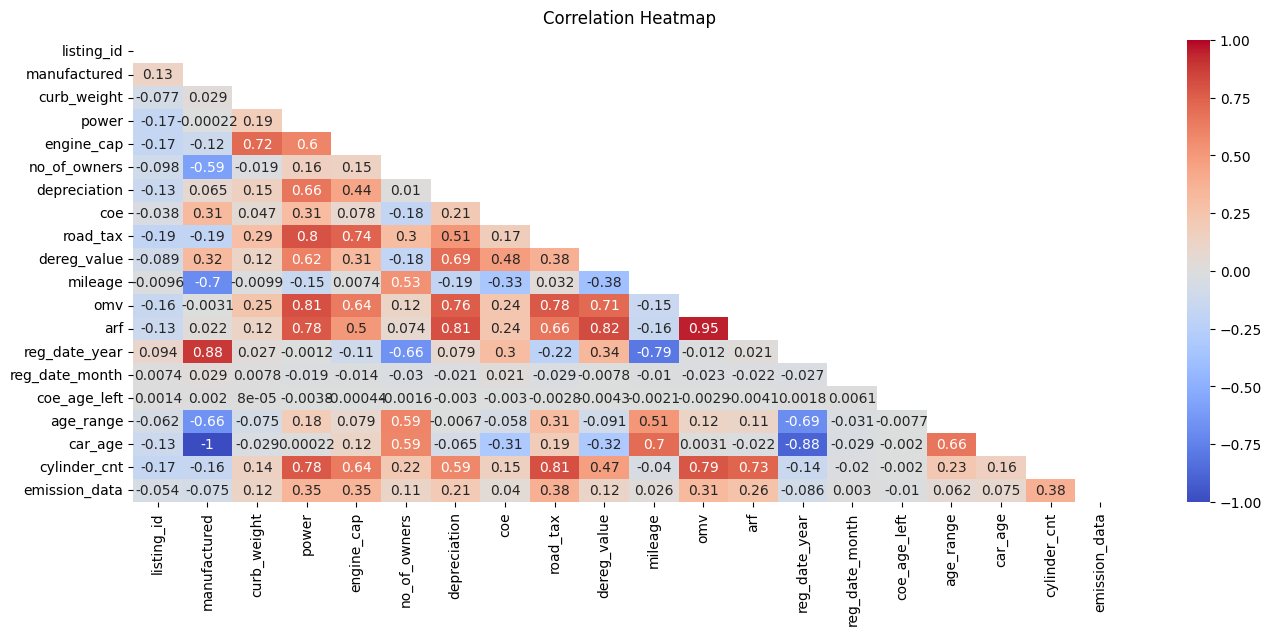

In [101]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.

corr_df = all_df[cols_with_var].corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
heatmap = sns.heatmap(corr_df, mask=mask, vmin=-1, vmax=1, annot=True,cmap='coolwarm')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [75]:
X_data[top_corr_features].corr()

,listing_id,manufactured,curb_weight,power,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,reg_date_year,reg_date_month,coe_age_left,age_range,car_age,cylinder_cnt,emission_data
listing_id,1.000000,0.125569,-0.077108,-0.169477,-0.166142,-0.098065,-0.134252,-0.037545,-0.191066,-0.089169,-0.009578,-0.155899,-0.129172,0.094194,0.007441,0.001395,-0.061702,-0.125569,-0.166011,-0.053773
manufactured,0.125569,1.000000,0.029203,-0.000217,-0.121305,-0.587100,0.064778,0.313660,-0.191813,0.315805,-0.699721,-0.003057,0.022123,0.883517,0.028942,0.002006,-0.658327,-1.000000,-0.159278,-0.075221
curb_weight,-0.077108,0.029203,1.000000,0.187402,0.717752,-0.018603,0.149972,0.047150,0.287641,0.117463,-0.009890,0.249514,0.121880,0.027401,0.007766,0.000080,-0.074797,-0.029203,0.143618,0.117602
power,-0.169477,-0.000217,0.187402,1.000000,0.595150,0.157634,0.658594,0.309686,0.802717,0.615869,-0.148551,0.807483,0.776345,-0.001152,-0.018877,-0.003755,0.184719,0.000217,0.775532,0.348332
engine_cap,-0.166142,-0.121305,0.717752,0.595150,1.000000,0.148367,0.439622,0.078232,0.736360,0.313172,0.007371,0.635963,0.500498,-0.105944,-0.013737,-0.000443,0.078756,0.121305,0.636663,0.350752
no_of_owners,-0.098065,-0.587100,-0.018603,0.157634,0.148367,1.000000,0.010300,-0.175582,0.302513,-0.183740,0.534403,0.122857,0.074308,-0.660055,-0.030462,-0.001645,0.594002,0.587100,0.224749,0.109999
depreciation,-0.134252,0.064778,0.149972,0.658594,0.439622,0.010300,1.000000,0.211028,0.508164,0.693055,-0.193231,0.763170,0.808642,0.078911,-0.020675,-0.003021,-0.006747,-0.064778,0.585637,0.206000
coe,-0.037545,0.313660,0.047150,0.309686,0.078232,-0.175582,0.211028,1.000000,0.172631,0.483715,-0.329552,0.236825,0.241231,0.300241,0.021072,-0.002982,-0.058226,-0.313660,0.152200,0.039921
road_tax,-0.191066,-0.191813,0.287641,0.802717,0.736360,0.302513,0.508164,0.172631,1.000000,0.378381,0.032457,0.777983,0.660784,-0.223939,-0.029483,-0.002821,0.306092,0.191813,0.810678,0.378184
dereg_value,-0.089169,0.315805,0.117463,0.615869,0.313172,-0.183740,0.693055,0.483715,0.378381,1.000000,-0.382966,0.712459,0.822177,0.340744,-0.007796,-0.004263,-0.090522,-0.315805,0.473725,0.116560


## [feature Engineering] Distribution Plots

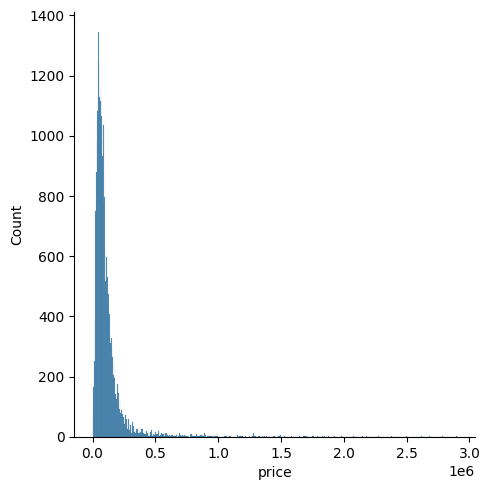

In [102]:
sns.displot(all_df, x="price")

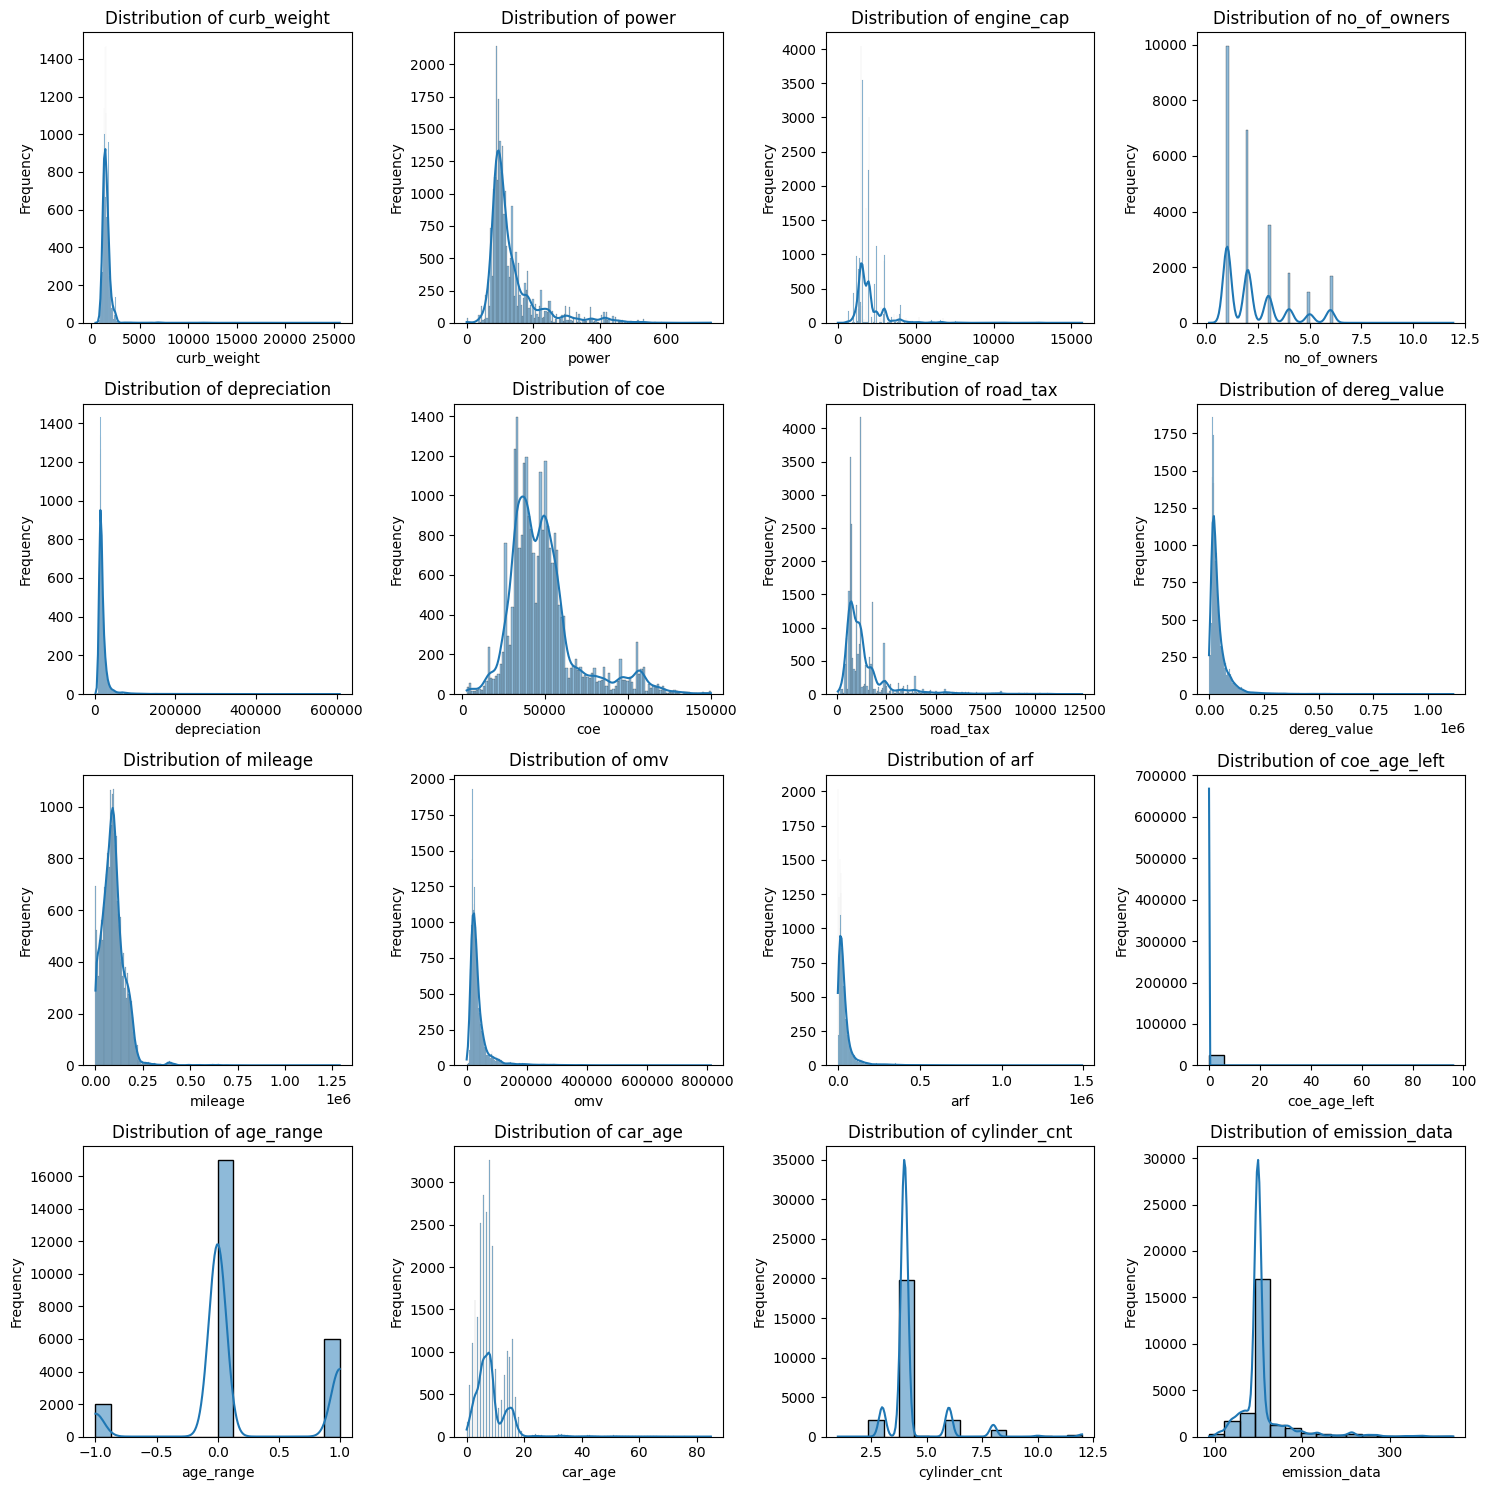

In [100]:
cols = ['curb_weight','power','engine_cap','no_of_owners','depreciation','coe','road_tax','dereg_value','mileage',
 'omv','arf','coe_age_left','age_range','car_age','cylinder_cnt','emission_data']

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Iterate over the numeric columns and create distribution plots
for i, column in enumerate(cols):
    sns.histplot(data=X_data, x=column, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {column}', fontsize=12)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(numeric_columns), len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Model Selection

Ref: https://github.com/esentri/datascience_blog_resources/blob/master/model_selection.ipynb

In [63]:
reg_dt =  tree.DecisionTreeRegressor(random_state=0)
reg_rf = ensemble.RandomForestRegressor(random_state=0)
reg_ridge = linear_model.Ridge()
reg_knn = KNeighborsRegressor()
reg_gb = ensemble.GradientBoostingRegressor(random_state=0)
reg_svr = svm.SVR()

pipe_ridge  = Pipeline([('std', StandardScaler()),
                     ('reg_ridge', reg_ridge)])

pipe_svr = Pipeline([('std', StandardScaler()),
                     ('reg_svr', reg_svr)])

pipe_knn = Pipeline([('std', StandardScaler()),
                     ('reg_knn', reg_knn)])

# Setting up the parameter grids
param_grid_lr  = [{'alpha': [0.01, 0.1, 1],
                    'fit_intercept': [True, False]}]

param_grid_knn = [{'clf_knn__n_neighbors': list(range(1, 10)),
                   'clf_knn__p': [1, 2],
                   'clf_knn__leaf_size': np.arange(10,51,10)}]

param_grid_rf  = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
                   'min_samples_leaf': [1, 3, 5],
                   'max_features': ['sqrt', 'log2']}]

param_grid_svc = [{
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],   # Kernel type
    'C': [0.1, 1, 10, 100],                    # Regularization parameter
    'epsilon': [0.01, 0.1, 0.5, 1, 2],               # Epsilon in the epsilon-SVR model
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1], # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'degree': [2, 3, 4]                              # Degree of the polynomial kernel function (only for 'poly' kernel)
}]

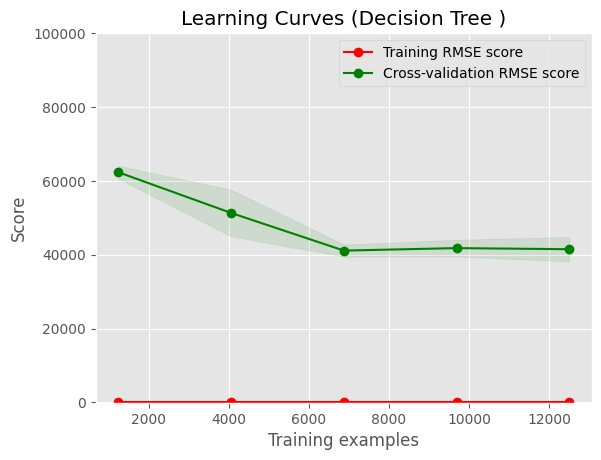

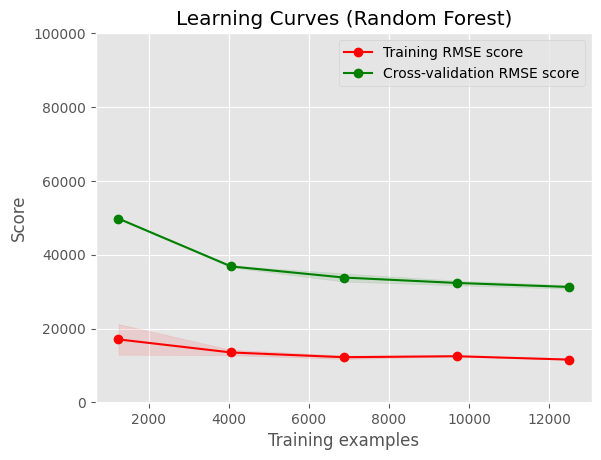

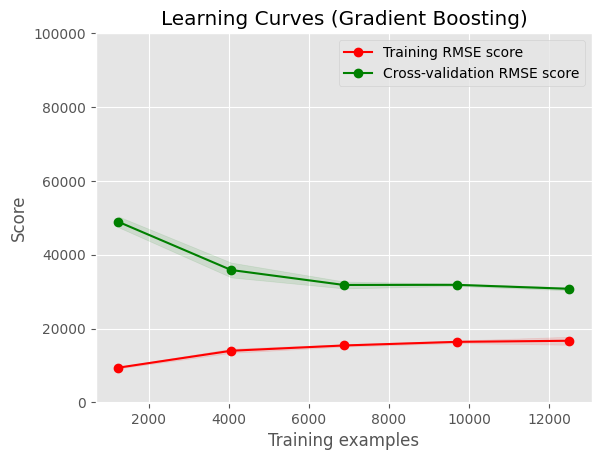

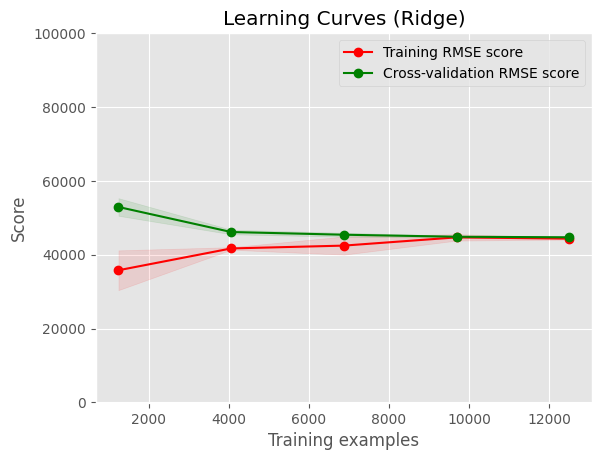

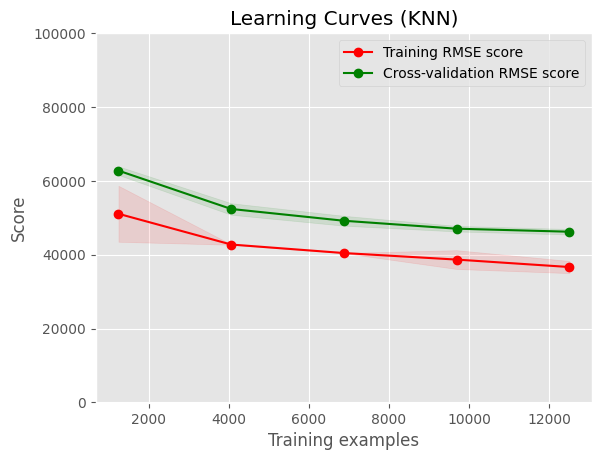

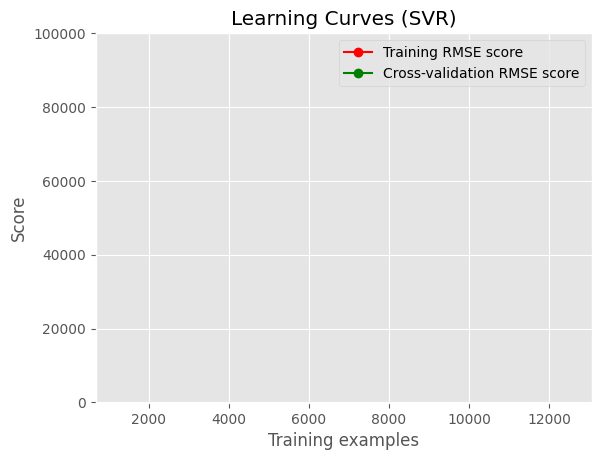

In [91]:
plt.style.use('ggplot')
%matplotlib inline

def plot_learning_curve(estimator, reg, X, y, ylim=None, cv=None, train_sizes=None):
    plt.figure()
    plt.title(f'Learning Curves ({reg})')
    plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring="neg_root_mean_squared_error")
    train_scores_mean = abs(np.mean(train_scores, axis=1))
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = abs(np.mean(test_scores, axis=1))
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training RMSE score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation RMSE score")

    plt.legend(loc="best")
    plt.grid(True)
    return

train_sizes = np.linspace(.1, 1.0, 5)
# ylim = (-1.01, 1.01)
ylim = (-100, 100000)
cv = 2
plot_learning_curve(reg_dt, "Decision Tree ", X_data, y_data, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)
plot_learning_curve(reg_rf, "Random Forest", X_data, y_data, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)
plot_learning_curve(reg_gb, "Gradient Boosting", X_data, y_data, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)

plot_learning_curve(pipe_ridge, "Ridge", X_data, y_data, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)
plot_learning_curve(pipe_knn, "KNN", X_data, y_data, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)
plot_learning_curve(pipe_svr, "SVR", X_data, y_data, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)

plt.show()

In [82]:
train_sizes, train_scores, test_scores = learning_curve(
    reg_rf, X_data, y_data, cv=3, train_sizes=[0.25, 0.5], scoring="neg_root_mean_squared_error")

In [87]:
np.std(train_scores, axis=1)

array([2342.7535754 ,  453.71280348])

In [84]:
np.mean(test_scores, axis=1)

array([-37909.45217969, -31994.76485575])

## Modelling

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    reg_rf, X_data, y_data, cv=2, train_sizes=[0.1  , 0.325], scoring="neg_mean_absolute_percentage_error")

In [9]:
features = ['curb_weight', 'power', 'cylinder_cnt', 'omv_new',
       'engine_cap', 'depreciation', 'mileage', 'dereg_value','no_of_owners','coe','type_of_vehicle_bus/mini bus', 'type_of_vehicle_hatchback',
       'type_of_vehicle_luxury sedan', 'type_of_vehicle_mid-sized sedan',
       'type_of_vehicle_mpv', 'type_of_vehicle_others',
       'type_of_vehicle_sports car', 'type_of_vehicle_stationwagon',
       'type_of_vehicle_suv', 'type_of_vehicle_truck', 'type_of_vehicle_van','car_age']

X_train, X_test, y_train, y_test = train_test_split(transformed_df[features], transformed_df['price'], test_size=0.3, random_state=42)


In [10]:
scaler = MinMaxScaler()
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train[features])

# Split data into training and test sets
X_train[features] = imputer.transform(X_train[features])
X_test[features] = imputer.transform(X_test[features])

# Fit and transform the numerical columns
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

In [ ]:
# 2. Initialize the Regression class
regressor = Regression()

# 3. Define parameters for hyperparameter tuning
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Example for Random Forest with accuracy scoring and KFold validation
tuner, best_params, tuner_results = regressor.hyperparameter_tuning(
    df_tuple=(X_train, y_train),   # The training data (X, y)
    score_metric='neg_root_mean_squared_error',       # Scoring metric
    kfold_type='kfold',            # Type of fold (KFold used here)
    n_splits=2,                    # Number of splits for KFold
    params=params,                 # Hyperparameter grid to search
    model_name='random_forest'      # Model to use (Random Forest in this case)
)

# 4. View the best hyperparameters and fit the model
print(f"Best Parameters: {best_params}")

# 5. Use the best model to predict on the test set
best_model = tuner.best_estimator_


In [ ]:
import joblib

# Save model 
model_name = "random_forest_v1"
save_path = f"./model_assets"
# Save the trained model
joblib.dump(best_model, f"{save_path}/{model_name}.joblib")

INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



{'Train RMSE ::': '9389.4', 'Train MAE': '2405.5', 'Train PMAE': '2.1280', 'Train PME ': '-0.601', 'Train R2': '0.996', 'Train Adj R2': '0.9964372360999576', 'Train Predicted R2': '0.9963382496871186'} {'Valid RMSE ::': '27468.', 'Valid MAE': '6536.5', 'Valid PMAE': '6.0360', 'Valid PME ': '-1.835', 'Valid R2': '0.966', 'Valid Adj R2': '0.9668970421897676', 'Valid Predicted R2': '0.9657315136268408'}


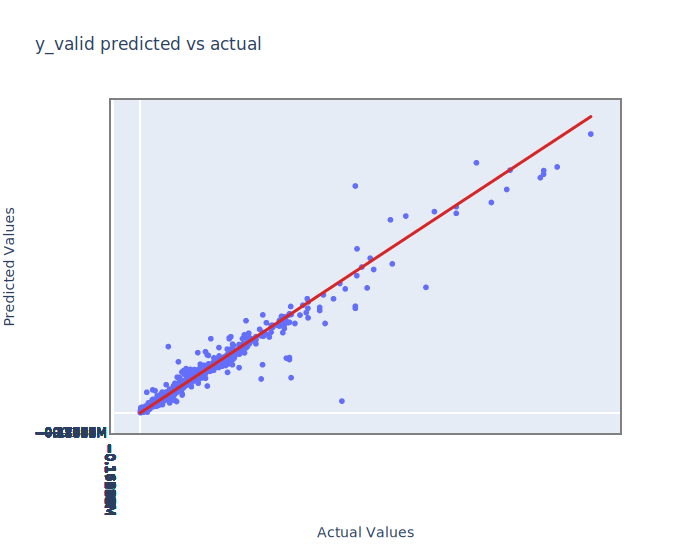

KeyboardInterrupt: 

In [11]:
model_name = "random_forest_v1"
save_path = f"./model_assets"
eval_util = RegressionEvaluate(save_path)
eval_util.regression_evaluate(df_train_tuple=(X_train, y_train),
df_valid_tuple=( X_test,y_test),model_name=model_name)


In [30]:
import joblib
import plotly.express as px
import plotly.graph_objects as go

def _infer_type(data) -> np.ndarray:

    ## type checker

    try:
        assert type(data) == np.ndarray, "incorrect type"

    except AssertionError:
        data = data.to_numpy()
        print("INFO [_infer_type] :: Type changed")
        return data

    else:
        return data

def mini_reg_evaluate(
    df_train_tuple: tuple, df_valid_tuple: tuple, model_name: str, save_path:str
):

    model = joblib.load(f"{save_path}/{model_name}.joblib")
    X_train, y_train = df_train_tuple[0], df_train_tuple[1]
    X_valid, y_valid = df_valid_tuple[0], df_valid_tuple[1]

    ## type checker

    X_train = _infer_type(X_train)
    y_train = _infer_type(y_train)
    X_valid = _infer_type(X_valid)
    y_valid = _infer_type(y_valid)

    # Train and validation scores
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    
    # Visualize scatter plot for validation data
    plt.scatter(y_valid, y_valid_pred, color='blue', alpha=0.5)
    plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], color='red', linestyle='--')
    plt.title("y_valid predicted vs actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    # Visualize scatter plot for training data
    plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
    plt.title("y_train predicted vs actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    # Visualize residual plot
    plt.scatter(y_valid_pred, y_valid_pred - y_valid, color='blue', alpha=0.5)
    plt.plot([y_valid_pred.min(), y_valid_pred.max()], [0, 0], color='red', linestyle='--')
    plt.title("Residual Plot (Validation Data)")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residual Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    plt.scatter(y_train_pred, y_train_pred - y_train, color='blue', alpha=0.5)
    plt.plot([y_train_pred.min(), y_train_pred.max()], [0, 0], color='red', linestyle='--')
    plt.title("Residual Plot (Training Data)")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residual Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
  

INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



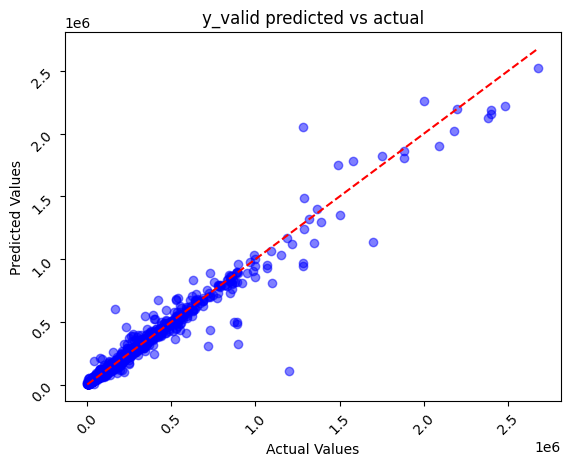

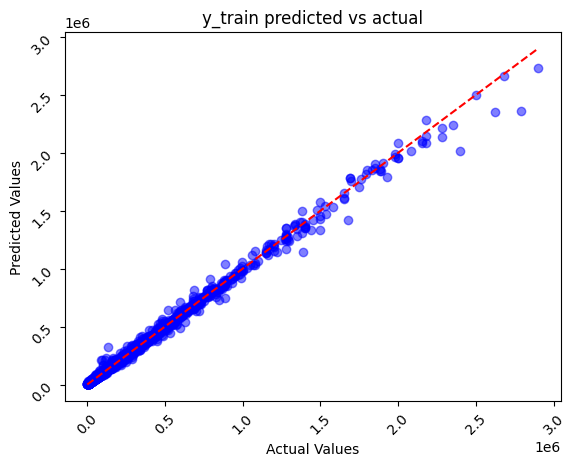

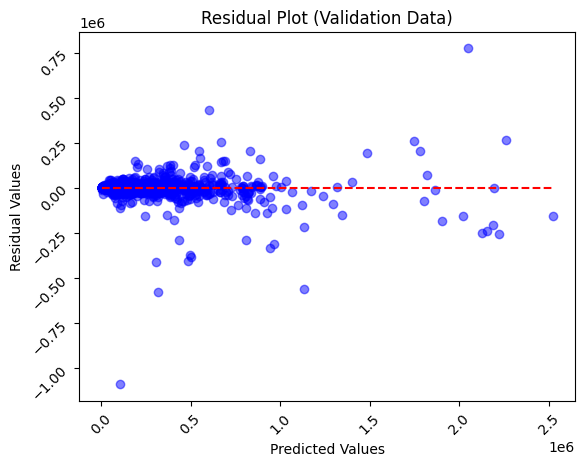

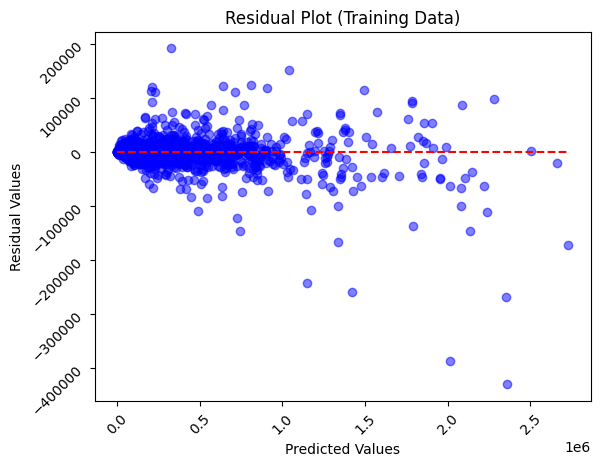

In [31]:
model_name = "random_forest_v1"
save_path = f"./model_assets"

mini_reg_evaluate(df_train_tuple=(X_train, y_train),
df_valid_tuple=( X_test,y_test),model_name=model_name, save_path=save_path)

### Appendix    

In [ ]:
from sklearn.utils import all_estimators

def get_all_regressors_sklearn():

    estimators = all_estimators(type_filter='regressor')

    all_regs = []
    for name, RegClass in estimators:
        print('Appending', name)
        try:
            reg = RegClass()
            all_regs.append(reg)
        except Exception as e:
            pass
    return all_regs

all_regs = get_all_regressors_sklearn()
print(all_regs)